In [1]:
from functions import *

# Etape 1 - Scrapping chart

##  A - Scrapping

In [2]:
years = [str(y) for y in np.arange(2004, 2023, 1)]
weeks = [int(v) for v in np.linspace(1, 52, 12)]
mois = ["janvier", "fevrier", "mars", "avril", "mai", "juin", "juillet", "aout", "septembre", "octobre", "novembre", "decembre"]

In [4]:
dfs_chart = {y : {} for y in years}
data = []

for y in tqdm(years):
    for k, w in enumerate(weeks):
        url = f"https://acharts.co/france_singles_top_100/{y}/{w}"
        rq = get(url)
        m = mois[k]
        if rq.ok:
            soup = BeautifulSoup(rq.text)

            chart = soup.find("table", {"id" : "ChartTable"})
            trs = chart.findAll("tr")[1:]

            for tr in trs:
                music_name = tr.find("span", {"itemprop" : "name"}).text.lower()
                rank = tr.find("span", {"itemprop" : "position"}).text.lower()
                artist_name = tr.find("span", {"itemprop" : "byArtist"}).text[2:-1].lower()
                data.append([m, y, str(rank), str(artist_name), str(music_name)])

charts = pd.DataFrame(data, columns=["mois", "annee", "rank", "artist", "music"])

100%|██████████| 19/19 [04:13<00:00, 13.33s/it]


In [5]:
#Export
charts.to_csv("../etapes/1 - scrapping chart/charts.csv", index=False, encoding="utf-8-sig")

## B - Analyse

In [6]:
#Load
charts = pd.read_csv("../etapes/1 - scrapping chart/charts.csv", encoding="utf-8-sig")

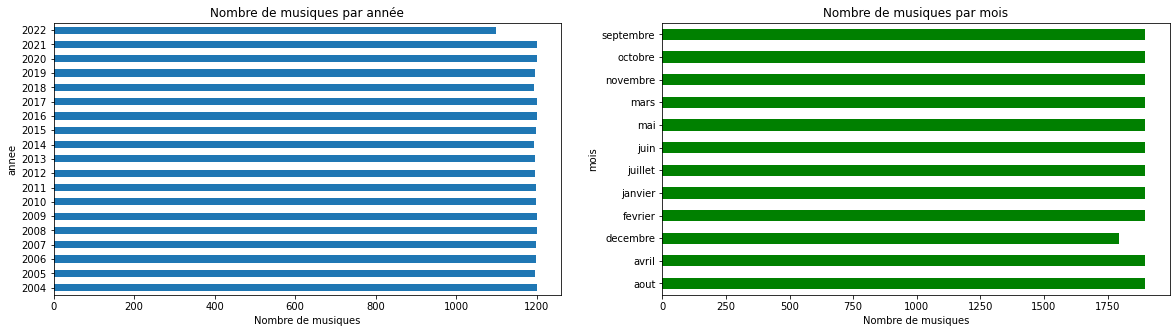

In [7]:
#Donnée par année
fig, ax = plt.subplots(1, 2, figsize=(20,5))
charts.groupby("annee")["music"].count().plot.barh(ax=ax[0])
ax[0].set(title="Nombre de musiques par année", xlabel="Nombre de musiques")

charts.groupby("mois")["music"].count().plot.barh(ax=ax[1], color="green")
ax[1].set(title="Nombre de musiques par mois", xlabel="Nombre de musiques")

plt.show()

# Etape 2 - Cleaning chart

## A - Cleaning

In [8]:
#Load
charts = pd.read_csv("../etapes/1 - scrapping chart/charts.csv", encoding="utf-8-sig")

In [9]:
names = [
    ("Djadja", "Djadja et Dinaz"),
    ("Lorie", "Lorie Pester"),
    ("-m-", "Matthieu Chedid"),
    ("Priscilla", "Priscilla Betti"),
    ("I Am", "IAM"),
    ("Sofiane", "Sofiane Zermani"),
    ("Justice", "Justice (groupe)"),
    ("Soma Riba", "Collectif Métissé"),
    ("Fresh", "Fresh la Peufra"),
    ("Rosalia", "Rosalía"),
    ("Italo Brothers", "ItaloBrothers"),
    ("Far\*east Movement", "Far East Movement"),
    ("Odyssey", "Odyssey (groupe)"),
    ("1789", "1789 : Les Amants de la Bastille"),
    ("Clemence", "Clémence Saint-Preux"),
    ("Rose", "Rose (chanteuse)"),
    ("Laeti", "Laetitia Kerfa"),
    ("La Troupe", "Mozart, l'opéra rock"),
    ("Victoria", "Victoria Sio"),
    ("Christine And The Queens", "Redcar (artiste)"),
    ("Earth and Wind And Fire", "Earth, Wind And Fire"),
    ("Jean Roch", "Jean-Roch"),
    ("Keen V", "Keen'V"),
    ("Dinor", "Dinor RDT"),
    ("Koba La D", "Koba LaD"),
    ("scotts", "Travis Scott"),
    ("louane emera", "louane"),
    ("maitre gims", "gims"),
    ("p!nk", "pink"),
    ("Eva", "Eva Queen"),
    ("dj tiësto", "tiesto"),
    ("Karol", "Karol G"),
    ("Khaled", "DJ Khaled"),
    ("Black Eyed Peas", "The Black Eyed Peas"),
    ("L.E.J", "LEJ"),
    ("Disiz la peste", "Disiz"),
    ("k'maro", "k. maro"),
    ("shin sekaï", "The Shin Sekaï"),
    ("the niro", "niro"),
    ("r.i.o.", "rio"),
    ("zayn", "zayn malik"),
    ("dimitri vegas", "dimitri vegas & like mike"),
    ("cauet", "Sébastien Cauet"),
    ("do", "the do"),
    ("les filles", "Aurélie Konaté")
]

replace_words = [
    ("\x9c", "oe"),
    ("œ", "oe"),
    ("$", "S"),
]

charts["artist"] = charts["artist"].str.split(" x ", regex=False).str[0]
charts["artist"] = charts["artist"].str.split(" - ", regex=False).str[-1]
charts["artist"] = charts["artist"].str.split(" \+ ", regex=False).str[0]

charts["artist"] = charts["artist"].apply(lambda x: "star academy" if "star academy" in x else x)

for n1, n2 in names:
    charts["artist"] = charts["artist"].apply(lambda x: n2.lower() if x.lower() == n1.lower() else x.lower())

for n1, n2 in replace_words:
    charts["artist"] = charts["artist"].str.replace(n1.lower(), n2.lower(), regex=False)


In [11]:
charts = add_id(charts, ["artist", "music"], "id_music")

In [12]:
#Export
charts.to_csv("../etapes/2 - cleanning chart/charts.csv", index=False, encoding="utf-8-sig")

## B - Analyse

In [13]:
#Load
charts = pd.read_csv("../etapes/2 - cleanning chart/charts.csv", encoding="utf-8-sig")

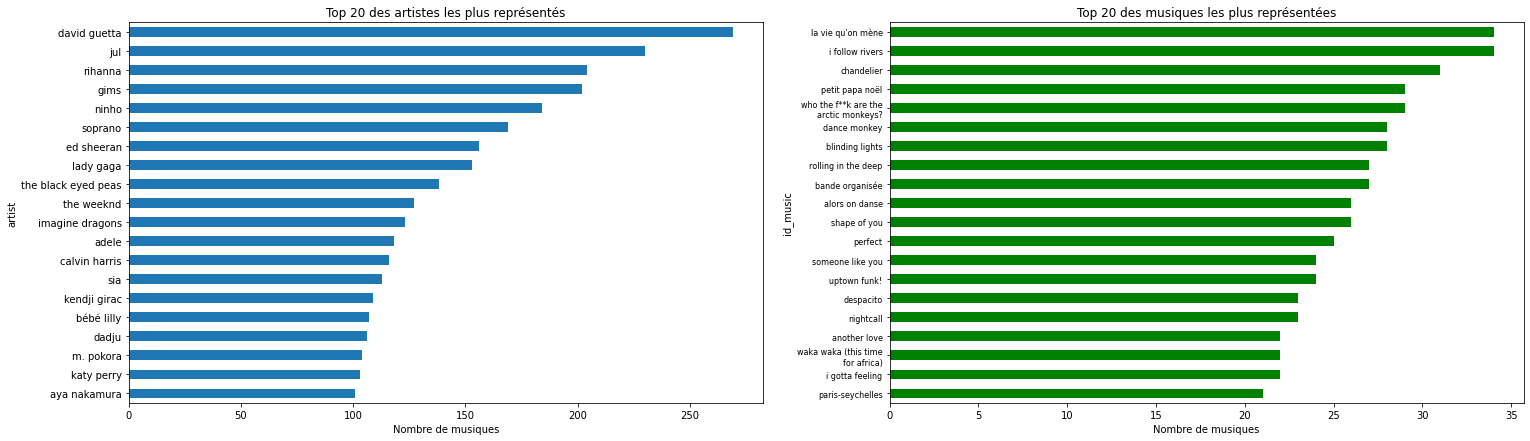

In [14]:
top = 20

fig, ax = plt.subplots(1, 2, figsize=(25,7))
charts.groupby("artist")["music"].count().sort_values().iloc[-top:].plot.barh(ax=ax[0])
ax[0].set(title=f"Top {top} des artistes les plus représentés", xlabel="Nombre de musiques")

charts.groupby("id_music")["artist"].count().sort_values().iloc[-top:].plot.barh(ax=ax[1], color="green")
ax[1].set(title=f"Top {top} des musiques les plus représentées", xlabel="Nombre de musiques")
ax[1].set_yticklabels(["\n".join(wrap(charts[charts["id_music"] == int(elem.get_text())].iloc[0,:]["music"], 20)) for elem in ax[1].get_yticklabels()], size=8)

plt.show()

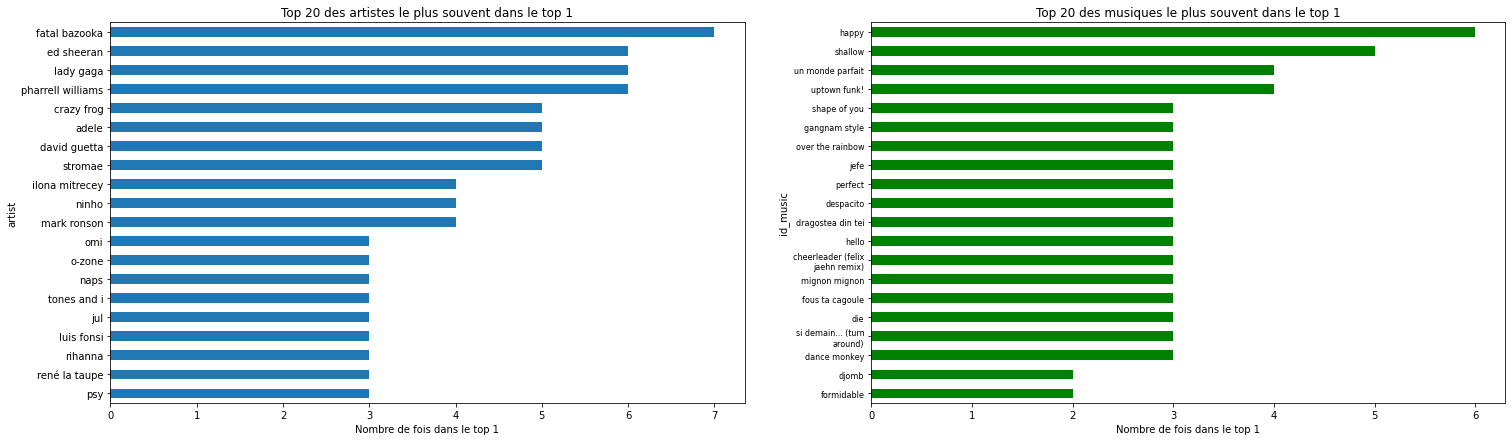

In [15]:
top = 1

fig, ax = plt.subplots(1, 2, figsize=(25,7))
charts.groupby("artist")["rank"].value_counts().unstack().iloc[:, :top].sum(axis=1).sort_values().iloc[-20:].plot.barh(ax=ax[0])
ax[0].set(title=f"Top 20 des artistes le plus souvent dans le top {top}", xlabel=f"Nombre de fois dans le top {top}")

charts.groupby("id_music")["rank"].value_counts().unstack().iloc[:, :top].sum(axis=1).sort_values().iloc[-20:].plot.barh(color="green", ax=ax[1])
ax[1].set(title=f"Top 20 des musiques le plus souvent dans le top {top}", xlabel=f"Nombre de fois dans le top {top}")
ax[1].set_yticklabels(["\n".join(wrap(charts[charts["id_music"] == int(elem.get_text())].iloc[0,:]["music"], 20)) for elem in ax[1].get_yticklabels()], size=8)

plt.show()

David Guetta est l'artiste qui a eu le souvent ses musiques dans les top 5 français. </br>
Shallow est la musique qui est revenu le plus souvent dans le top 5.

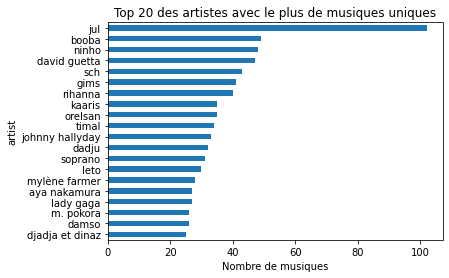

In [16]:
charts.groupby("artist")["id_music"].unique().agg(len).sort_values()[-20:].plot.barh()
plt.title("Top 20 des artistes avec le plus de musiques uniques")
plt.xlabel("Nombre de musiques")
plt.show()

Jul est l'artiste avec le plus de musique unique dans le top 100 depuis 2004

# Etape 3 : Scrapping artist data

## A - Scrapping

In [139]:
#Load
charts = pd.read_csv("../etapes/2 - cleanning chart/charts.csv", encoding="utf-8-sig")

In [142]:
#Récupére tous les artistes uniques
artist = pd.DataFrame(charts["artist"].unique(), columns=["artist"])

In [143]:
artist["wiki name"] = artist["artist"].apply(lambda x : find_title_in_wikipedia(x, 0.2)) #Trouve les pages wikipedia de chaque artistes

In [144]:
birth_dic = artist["wiki name"].apply(wiki_birth) #Cherche les infos de naissance sur les pages wikipedia

C:\Users\CYTech Student\AppData\Roaming\Python\Python38\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\CYTech Student\AppData\Roaming\Python\Python38\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [148]:
#Transforme les infos trouver sur wikipédia en dataframe
dfs_birth = []
for dic in birth_dic:
    dfs_birth.append(pd.DataFrame(dic, index=[0]))
birth = pd.concat(dfs_birth, ignore_index=True)
birth.columns = ["naissance", "pays d'origine", "origine", "nationalite", "pays", "summary"]

In [153]:
#Merge les infos de naissance avec les infos des artistes
artist = artist.merge(birth, left_index=True, right_index=True)

In [154]:
#On ajoute manuellement les informations pour les artistes importants qui n'ont pas été trouvé sur wikipedia
manuel_names = [
    ("sound of legend", "manuel", np.NaN, np.NaN, np.NaN, "français", np.NaN, np.NaN),
    ("al. hy", "manuel", "15 novembre 1993", np.NaN, np.NaN, "français", np.NaN, "15 novembre 1993 (Âge: 29 ans), Saint-Amand-les-Eaux"),
    ("glk", "manuel", np.NaN, np.NaN, np.NaN, "français", np.NaN, "Originaire de Bobigny, en Seine-Saint-Denis"),
    ("paul glaeser", "manuel", "1963", np.NaN, np.NaN, "français", np.NaN, np.NaN),
    ("bolémvn", "manuel", "29 novembre 1996", np.NaN, np.NaN, "français", np.NaN, "Bryan Mounkala (né le 29 novembre 1996) mieux connu sous le nom de Bolémvn est un rappeur français d'Évry, Essonne, Île-de-France, France."),
    ("1pliké140", "manuel", "1963", np.NaN, np.NaN, "français", np.NaN, "1PLIKÉ140 est un jeune rappeur français originaire de Clamart (92) en banlieue parisienne."),
    ("jérôme collet", "manuel", np.NaN, np.NaN, np.NaN, "français", np.NaN, np.NaN),
    ("tom snare", "manuel", np.NaN, np.NaN, np.NaN, "français", np.NaN, "Xavier Decanter, mieux connu sous son nom de scène Tom Snare, est un DJ et producteur de disques français originaire de Dunkerque."),
    ("funnybear", "manuel", "22 janvier 1991", np.NaN, np.NaN, "français", np.NaN, "22 janvier 1991 (Âge: 31 ans), Hyères"),
    ("landy", "manuel", "2000", np.NaN, np.NaN, "français", np.NaN, "Dylan Sylla Gahoussou, « Landy » de son nom de scène, est né dans le XIXe arrondissement de Paris"),
    ("dry", "manuel", "19 novembre 1977", np.NaN, np.NaN, "français", np.NaN, "Landry Delica a grandi à Sevran en Seine-Saint-Denis"),
    ("sasso", "manuel", np.NaN, np.NaN, np.NaN, "français", np.NaN, "Né à Vénissieux d'un père togolais et d'une mère marocaine"),
    ("neïman", "manuel", np.NaN, np.NaN, np.NaN, "guyanais", np.NaN, "NEÏMAN est un chanteur et toaster français de dancehall et de reggae-soul né RAY NEÏMAN en Guyane."),
    ("isk", "manuel", "20 mars 2003", np.NaN, np.NaN, "français", np.NaN, "ISK, de son vrain nom Kais Ben Baccar, est un rappeur français d'origine tunisienne, né au Canada. Habitant La Ferté-sous-Jouarre (77), il est membre du label Bendo 11 Records sous la division rap GrandLine."),
    ("yaro", "manuel", "1996", np.NaN, np.NaN, "français", np.NaN, "Yaro, anciennement Sirsy, est un rappeur français originaire de la ville de Yerres dans l'Essonne.")
]

In [155]:
manuel_artist = pd.DataFrame(manuel_names, columns=["name", "wiki name", "naissance", "pays d'origine", "origine", "nationalite", "pays", "summary"])

In [161]:
artist_to_drop = artist[artist["artist"].isin(manuel_artist["name"])].index
artist.drop(index=artist_to_drop, inplace=True)
artist.rename(columns={"artist" : "name"}, inplace=True)

In [164]:
artist = pd.concat([artist, manuel_artist])

In [165]:
#Export
artist.to_csv("../etapes/3 - scrapping artist data/artist.csv", encoding="utf-8-sig", index=False)

## B - Analyse

In [166]:
#Load
artist = pd.read_csv("../etapes/3 - scrapping artist data/artist.csv", encoding="utf-8-sig")

In [167]:
artist.value_counts("wiki name").value_counts() #Aucune page en wiki en double, ce qui est un bon signe !

1     1700
15       1
dtype: int64

In [168]:
charts_c = charts.copy().drop(columns=["rank", "annee", "mois"]).drop_duplicates()
charts_c = charts_c.merge(artist, left_on="artist", right_on="name", how="left")

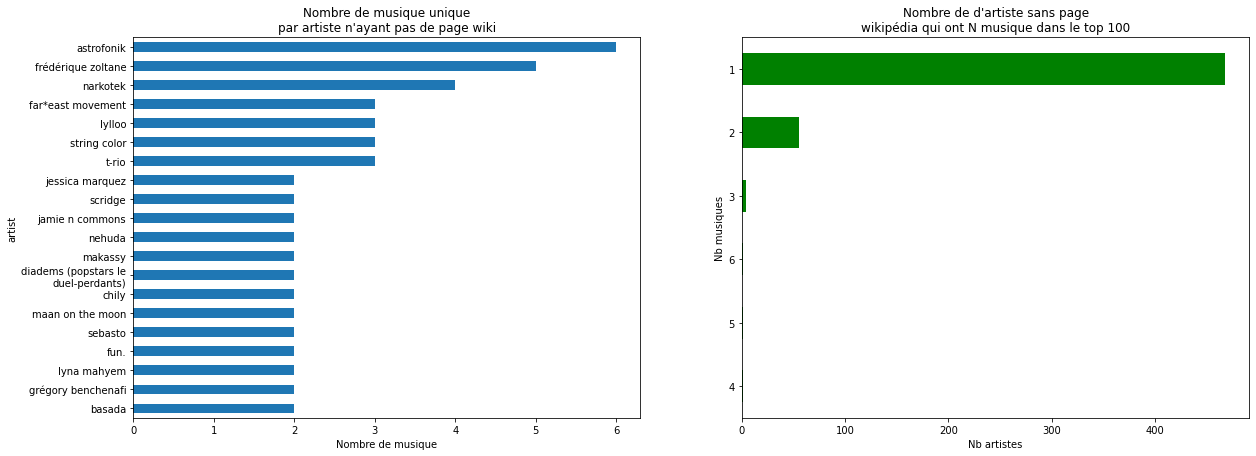

In [169]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))

charts_c[charts_c["wiki name"].isna()].groupby("artist")["music"].count().sort_values()[-20:].plot.barh(ax=ax[0])
ax[0].set(title="Nombre de musique unique\npar artiste n'ayant pas de page wiki", xlabel="Nombre de musique")
ax[0].set_yticklabels(["\n".join(wrap(elem.get_text(), 20)) for elem in ax[0].get_yticklabels()])


charts_c[charts_c["wiki name"].isna()].groupby("artist")["music"].count().value_counts()[::-1].plot.barh(ax=ax[1], color="green")
ax[1].set(xlabel="Nb artistes", ylabel="Nb musiques", title="Nombre de d'artiste sans page\nwikipédia qui ont N musique dans le top 100")
plt.show()

On remarque qu'il y a beaucoup d'artistes qui n'ont fait qu'une ou deux musiques populaires, ce qui parait logique de ne pas trouver beaucoup d'information sur eux. </br>
Seul quelques artistes sortent du lot, et après recherche, soit l'artiste n'est pas français, soit il y a trop peu d'infos sur eux.

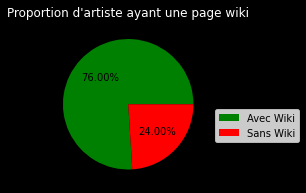

In [171]:
pie_chart(artist, "wiki name", "Proportion d'artiste ayant une page wiki", legends=["Avec Wiki", "Sans Wiki"])

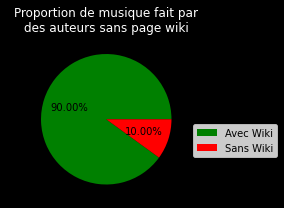

In [172]:
pie_chart(charts_c, "wiki name", "Proportion de musique fait par\ndes auteurs sans page wiki", legends=["Avec Wiki", "Sans Wiki"])

In [173]:
artist = artist[~artist["wiki name"].isna()] #On ne garde que les artistes qui ont une page wiki

In [174]:
#On recalcul les distances entre les noms d'artistes et les pages wikipédia pour vérifier
def calc_dist(artist, wiki):
    if wiki == "manuel":
        return 0

    words = ["(chanteur)", "(chanteuse)", "(groupe)", "(rappeur)", "(rappeuse)", "(musicien)", "(chanteur français)", "(france)", "(producteur)", "(artiste)", "(groupe de musique)"]

    if any(w in wiki.lower() for w in words):
        dist = edit_distance(artist.lower().strip(), wiki.lower().split(" (")[0].strip())
        if dist/len(artist) < 0.4:
            return dist
    
    return edit_distance(artist.lower().strip(), wiki.lower().strip())

In [175]:
artist["distance"] = artist.apply(lambda x: calc_dist(x["name"], x["wiki name"]), axis=1)
artist["distance norm"] = artist.apply(lambda x : x["distance"]/len(x["name"]), axis=1)

In [176]:
artist.sort_values("distance norm", ascending=False).head() #Nos distances sont bonnes

,name,wiki name,naissance,pays d'origine,origine,nationalite,pays,summary,distance,distance norm
887,ouf le prof,Ouf le prof !,NaN,france,NaN,NaN,france,ouf le prof !,2,0.181818
1551,simon & garfunkel,Simon and Garfunkel,NaN,états-unis,NaN,NaN,états-unis,simon and garfunkel [ˈsaɪmən ən gɑrfʌnkəl] est...,3,0.176471
760,gullia,Gulli,NaN,NaN,NaN,NaN,france,NaN,1,0.166667
20,cerena,Cérena,20 juin 1981 (41 ans)bastia (haute-corse),NaN,NaN,NaN,NaN,"cérena, de son vrai nom marie-ange cerezuela, ...",1,0.166667
1138,the do,The Dø,NaN,france,NaN,NaN,france,the dø [ðœ do] est un groupe français d'indie...,1,0.166667


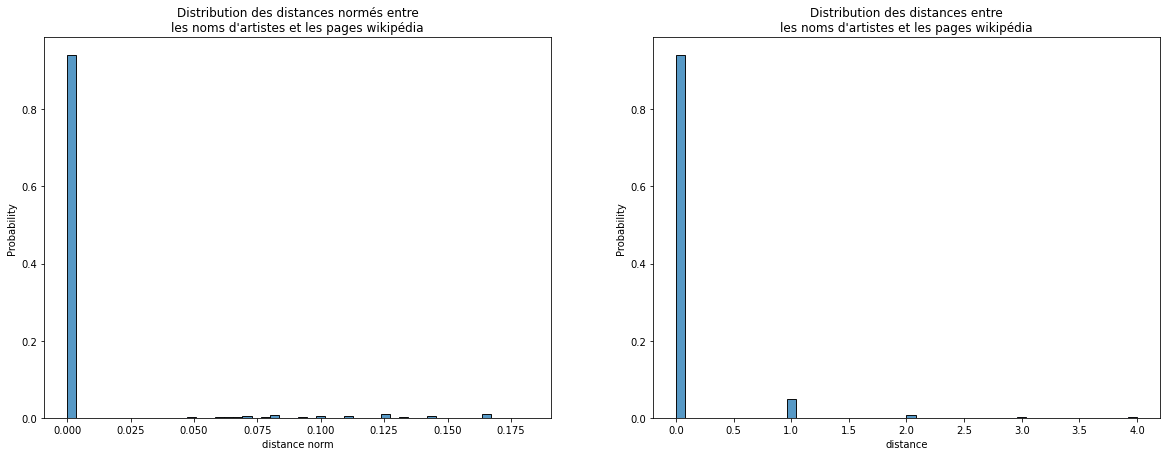

In [177]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))

sns.histplot(x = "distance norm", data=artist, bins=50, stat="probability", ax=ax[0])
ax[0].set_title("Distribution des distances normés entre\nles noms d'artistes et les pages wikipédia")

sns.histplot(x = "distance", data=artist, bins=50, stat="probability", ax=ax[1])
ax[1].set_title("Distribution des distances entre\nles noms d'artistes et les pages wikipédia")

plt.show()

# Etape 4 : Cleanning wikipedia results

## A - nationalite/pays

In [178]:
#Load
artist = pd.read_csv("../etapes/3 - scrapping artist data/artist.csv", encoding="utf-8-sig")
charts = pd.read_csv("../etapes/2 - cleanning chart/charts.csv", encoding="utf-8-sig")

In [179]:
nationality_cols = ["nationalite", "origine", "pays", "pays d'origine"]

### 1 - artiste sans donnée

In [180]:
artist_org = artist.copy()

In [181]:
#Ajout de la colonne "no data" pour voir ceux sur qui on n'a pas de données
artist["no data"] = (
    (artist["naissance"].isna()) &
    (artist["pays d'origine"].isna()) &
    (artist["origine"].isna()) &
    (artist["nationalite"].isna()) &
    (artist["pays"].isna()) &
    (artist["summary"].isna())
)

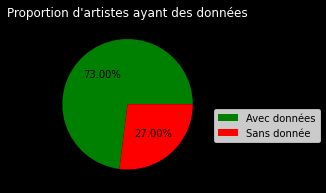

In [182]:
pie_chart(artist, "no data", "Proportion d'artistes ayant des données", False, ["Avec données", "Sans donnée"])

In [183]:
charts_c = charts.copy().merge(artist, left_on="artist", right_on="name", how="right")

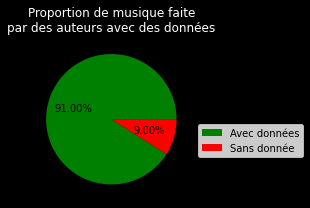

In [184]:
pie_chart(charts_c, "no data", "Proportion de musique faite\npar des auteurs avec des données", False, ["Avec données", "Sans donnée"])

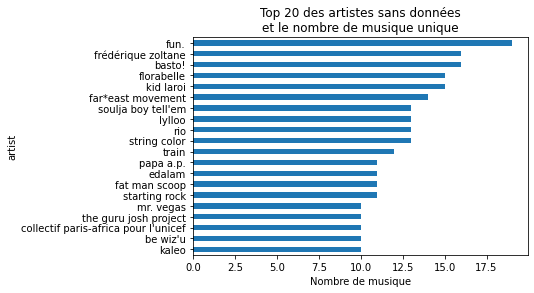

In [185]:
charts_c[charts_c["no data"]].groupby("artist")["music"].count().sort_values()[-20:].plot.barh()
plt.title("Top 20 des artistes sans données\net le nombre de musique unique")
plt.xlabel("Nombre de musique")
plt.show()

In [186]:
artist = artist[~artist["no data"]] #On ne garde que les artistes pour lesquels on a des données

### 2 - Normalisation des nationalites et pays récupéré

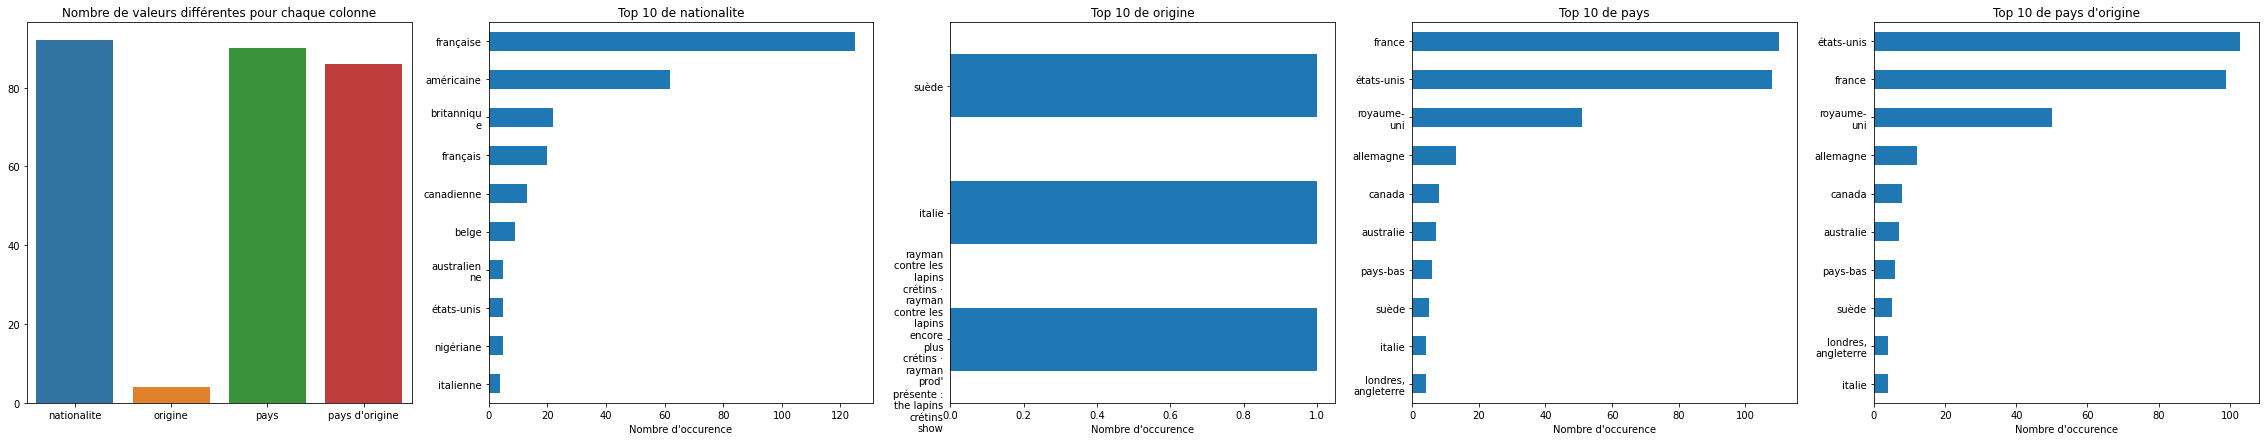

In [188]:
category_count(nationality_cols, artist, top=10)

On se rends compte qu'il y a pleins de nationalite/pays différents et qu'on pourrait en grouper certain.

In [189]:
#On supprime les textes dépassant les 40 caractères
for col in nationality_cols:
    artist.loc[~artist[col].isna(), col] = artist.loc[~artist[col].isna(), col].apply(lambda x: np.NaN if len(x) > 40 else x)

In [190]:
#Importation des pays et des gentillé associer
gentille_df = pd.read_csv("../monde/gentille.csv")
gentille = gentille_df["gentille"].drop_duplicates().tolist()
pays = gentille_df["pays"].drop_duplicates().tolist()

In [191]:
#On cherche dans les pays si on trouve quelque chose de connu
for p in pays:
    rgx = r"([\d)()\], ]|^)"+ p.lower() + r"([.,\[) ]|$)"
    artist.loc[artist["pays"].str.contains(rgx, regex=True, na=False), "pays"] = p
    artist.loc[artist["pays d'origine"].str.contains(rgx, regex=True, na=False), "pays d'origine"] = p

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_4280\1880322595.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  artist.loc[artist["pays"].str.contains(rgx, regex=True, na=False), "pays"] = p
C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_4280\1880322595.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  artist.loc[artist["pays d'origine"].str.contains(rgx, regex=True, na=False), "pays d'origine"] = p


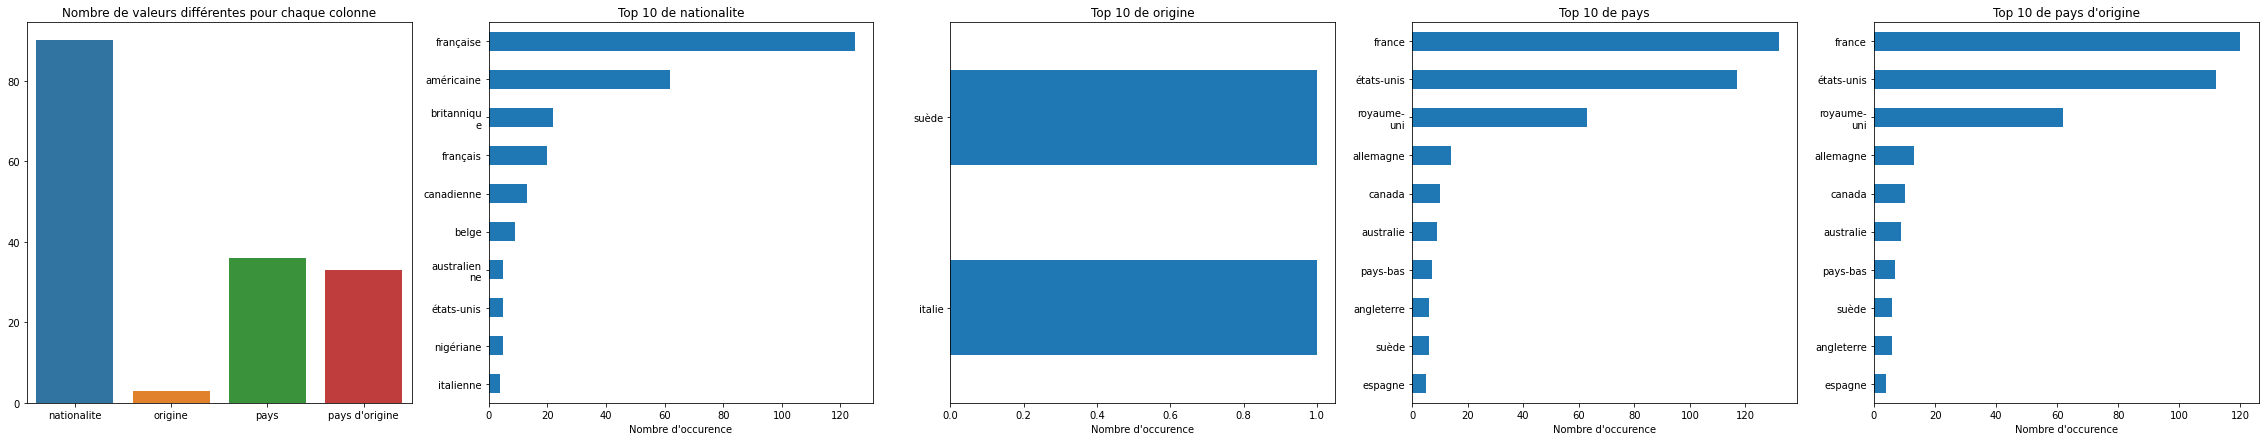

In [192]:
category_count(nationality_cols, artist)

On a enlevé les valeurs aberrantes et réduit de moitié pays et pays d'origne.

In [193]:
#Cela va permettre de normaliser les noms des pays et des nationalites
def cleanning(data, replace_words, p=0.3):
    if data is np.NaN:
        return np.NaN
    
    distances = []
    for r in replace_words:
        distances.append(edit_distance(data.lower(), r.lower())/len(data))
    return replace_words[np.argmin(distances)] if np.min(distances) < p else np.NaN

In [194]:
artist["nationalite"] = artist["nationalite"].apply(lambda x : cleanning(x, gentille))

In [195]:
artist["origine"] = artist["origine"].apply(lambda x : cleanning(x, pays))
artist["pays"] = artist["pays"].apply(lambda x : cleanning(x, pays))
artist["pays d'origine"] = artist["pays d'origine"].apply(lambda x : cleanning(x, pays))

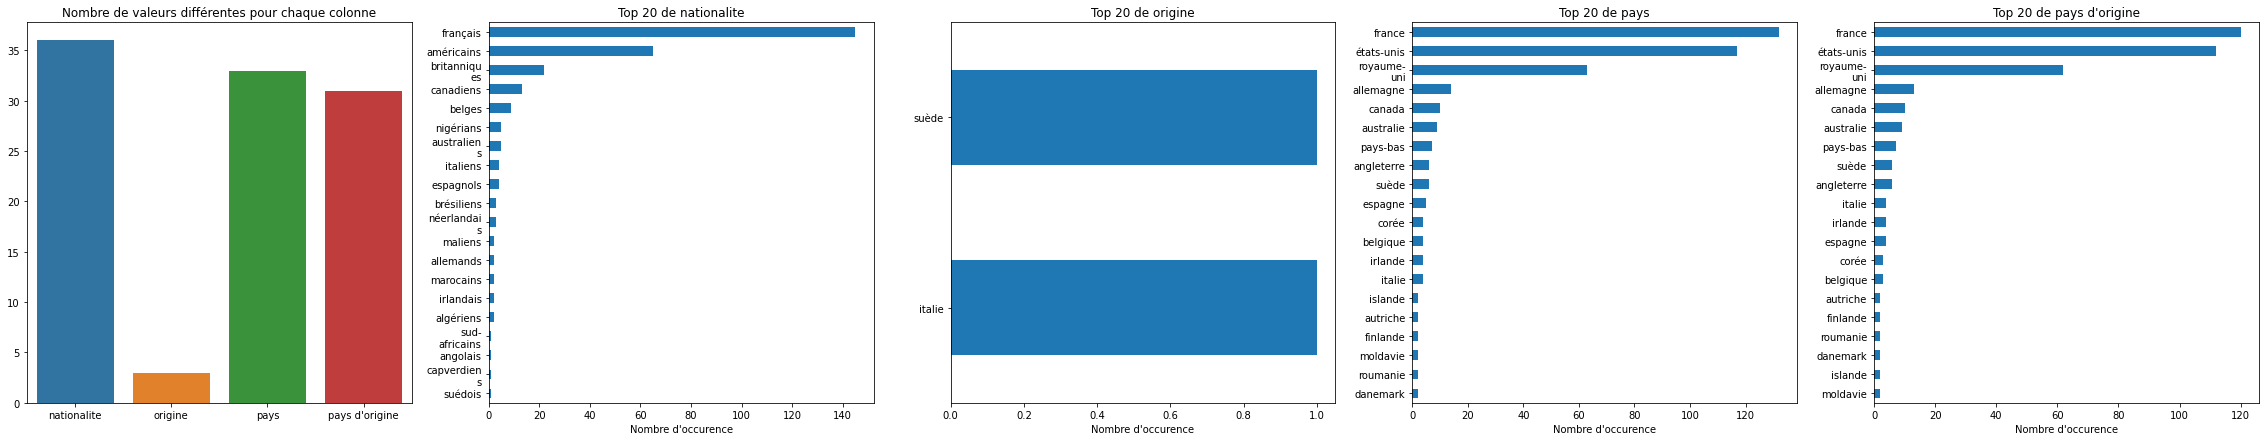

In [196]:
category_count(nationality_cols, artist, top=20)

### 3 - Récupération de nouvelles nationalites et pays

Maintenant que nous avons normalisé l'écriture des pays et nationalite on va essayer d'en chercher de nouveau pour les artistes qui n'en n'ont pas. A l'aide du summary et naissance.

In [197]:
artist["no nationalite"] = (
    (artist["nationalite"].isna()) &
    (artist["origine"].isna()) &
    (artist["pays"].isna()) &
    (artist["pays d'origine"].isna())
)

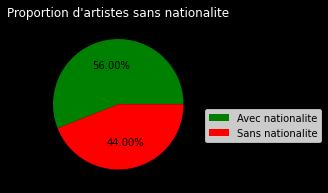

In [198]:
pie_chart(artist, "no nationalite", "Proportion d'artistes sans nationalite", False, ["Avec nationalite", "Sans nationalite"])

In [200]:
#On utilise le summary pour récupérer la nationalite
avant = artist[artist["nationalite"].isna()].shape[0]

nats = artist[~artist["nationalite"].isna()]["nationalite"].unique()
artist.loc[artist["nationalite"].isna(), "nationalite"] = artist.loc[artist["nationalite"].isna(), "summary"].apply(lambda x: get_nationality(x, nats))         #Je récupère une première fois avec les nationalites déjà connues
artist.loc[artist["nationalite"].isna(), "nationalite"] = artist.loc[artist["nationalite"].isna(), "summary"].apply(lambda x: get_nationality(x, gentille))     #Je récupère une deuxième fois avec les gentilles

apres = artist[artist["nationalite"].isna()].shape[0]

print(f"On a récupéré {avant-apres} nationalites")

On a récupéré 348 nationalites


In [201]:
#On utilise le summary pour récupérer la pays
avant = artist[(artist["pays"].isna()) & (artist["nationalite"].isna())].shape[0]

artist.loc[(artist["pays"].isna()) & (artist["nationalite"].isna()), "pays"] = artist.loc[(artist["pays"].isna()) & (artist["nationalite"].isna()), "naissance"].apply(lambda x: get_nationality(x, pays)) #Je récupère une première fois sur les naissances
artist.loc[(artist["pays"].isna()) & (artist["nationalite"].isna()), "pays"] = artist.loc[(artist["pays"].isna()) & (artist["nationalite"].isna()), "summary"].apply(lambda x: get_nationality(x, pays))   #Je récupère une deuxième fois sur le summary

apres = artist[(artist["pays"].isna()) & (artist["nationalite"].isna())].shape[0]

print(f"On a récupéré {avant - apres} pays")

On a récupéré 507 pays


In [202]:
#Mise à jour
artist["no nationalite"] = (
    (artist["nationalite"].isna()) &
    (artist["origine"].isna()) &
    (artist["pays"].isna()) &
    (artist["pays d'origine"].isna())
)

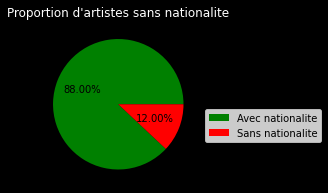

In [203]:
pie_chart(artist, "no nationalite", "Proportion d'artistes sans nationalite", False, ["Avec nationalite", "Sans nationalite"])

In [204]:
avant = artist[artist["nationalite"].isna()].shape[0]

In [205]:
for col in gentille_df.columns:
    gentille_df[col] = gentille_df[col].str.strip()

gentille = pd.DataFrame.to_dict(gentille_df.set_index("pays"), orient="dict").get("gentille")

In [206]:
#On récupère la nationalite à partir du pays et origine
for k, v in gentille.items():
    artist.loc[(artist["nationalite"].isna()) & (artist["pays"] == k), "nationalite"] = v
    artist.loc[(artist["nationalite"].isna()) & (artist["pays d'origine"] == k), "nationalite"] = v
    artist.loc[(artist["nationalite"].isna()) & (artist["origine"] == k), "nationalite"] = v

In [207]:
apres = artist[artist["nationalite"].isna()].shape[0]
print(f"On a récupéré {avant-apres} nationalites")

On a récupéré 788 nationalites


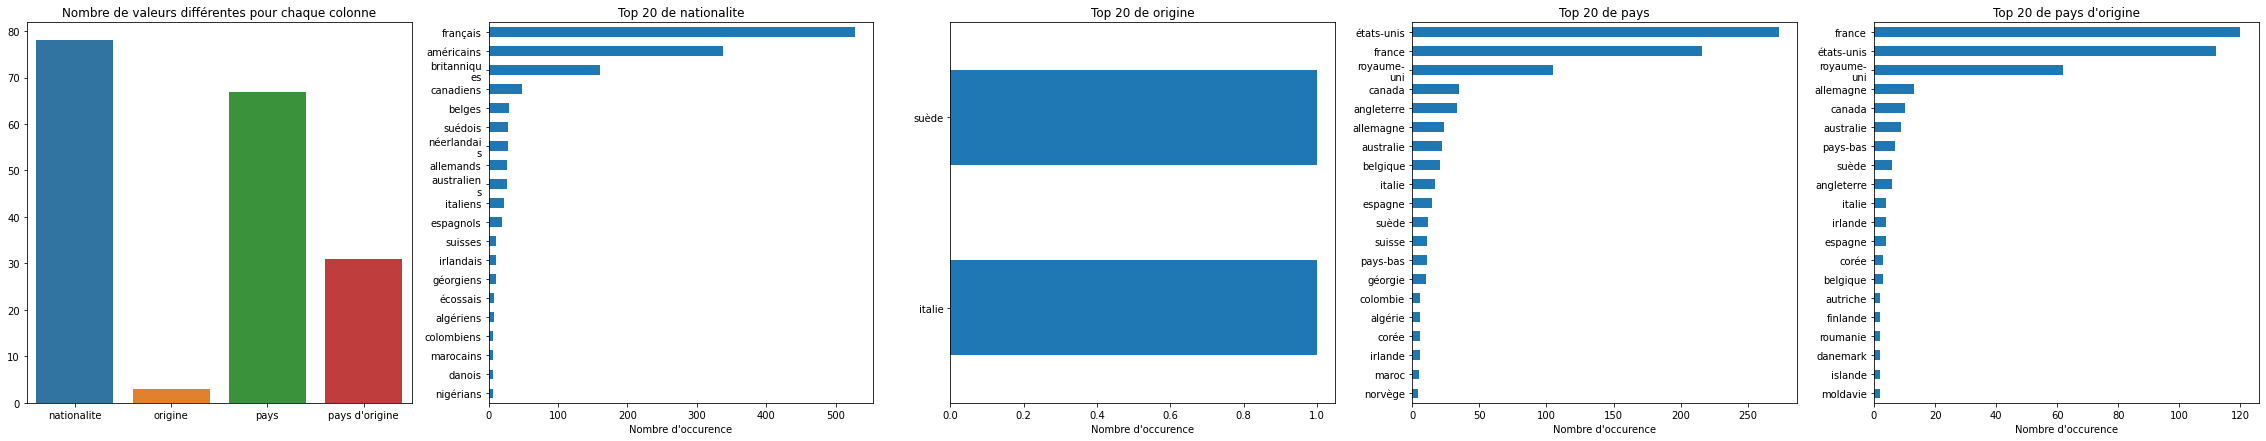

In [208]:
category_count(nationality_cols, artist, top=20)

In [210]:
charts_c = charts.copy().merge(artist, left_on="artist", right_on="name", how="left").drop(columns=["rank","annee", "mois"]).drop_duplicates()

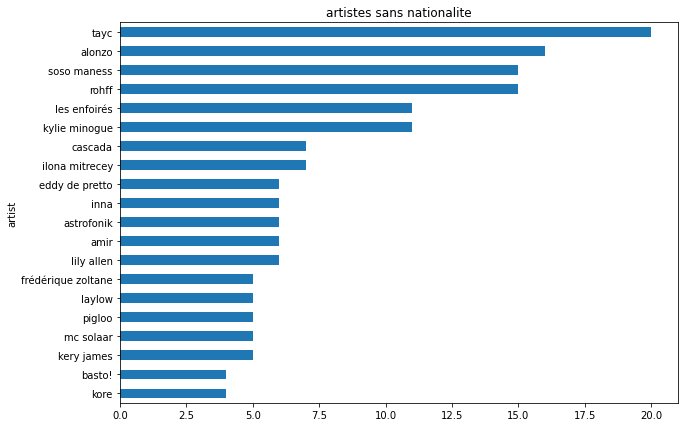

In [211]:
charts_c[charts_c["nationalite"].isna()].groupby("artist")["music"].count().sort_values()[-20:].plot.barh(figsize=(10,7))
plt.title("artistes sans nationalite")
plt.show()

In [213]:
#Export
artist.to_csv("../etapes/4 - cleanning wikipedia results/nationalite_pays/artist.csv", encoding="utf-8-sig", index=False)

## B - commune/departement/region

In [214]:
#Load
artist = pd.read_csv("../etapes/4 - cleanning wikipedia results/nationalite_pays/artist.csv", encoding="utf-8-sig")

In [215]:
#Importation des données
region = pd.read_csv("../france/departements-france.csv")
departement = pd.read_csv("../france/departements-france.csv")
commune = pd.read_csv("../france/communes-departement-region.csv")
nb_habitant = pd.read_csv("../france/nb_habitant.csv")

In [216]:
#On supprime les colonnes inutiles
commune = commune.drop(columns = ["code_commune_INSEE", "nom_commune_postal", "code_postal", "libelle_acheminement", "ligne_5", "latitude", "longitude", "code_commune", "article", "code_departement", "code_region", "nom_commune"])

#On rename la colonne nom_commune_complet en nom_commune
commune = commune.rename(columns={"nom_commune_complet": "nom_commune"})

#On enleve les arrondisement des villes
commune.loc[commune["nom_commune"].str.contains(r"[A-Za-z]* [0-9]{2}"), "nom_commune"] = commune.loc[commune["nom_commune"].str.contains(r"[A-Za-z]* [0-9]{2}"), "nom_commune"].str[:-3]

#On ajoute le nombre d'habitant au commune
commune = commune.merge(nb_habitant[["Ville", "nb_habitant"]], left_on="nom_commune", right_on="Ville", how="inner").drop(columns=["Ville"]).dropna().drop_duplicates()

#On transforme le nb d'habitant en int
commune["nb_habitant"] = commune["nb_habitant"].str.replace(" ", "")
commune["nb_habitant"] = commune["nb_habitant"].astype("int")

#On transforme tout en lower
for col in commune.select_dtypes("object").columns:
    commune[col] = commune[col].str.lower()

In [218]:
#On récupère la région
artist["region"] = artist.apply(lambda x: get_localisation(x, commune["nom_region"]), axis=1)

In [219]:
#On récupère la commune
artist["commune"] = artist.apply(lambda x: get_localisation(x, commune[commune["nb_habitant"] > 2000]["nom_commune"]), axis=1)

In [220]:
#On récupère le département
artist["departement"] = artist.apply(lambda x: get_localisation(x, commune["nom_departement"]), axis=1)

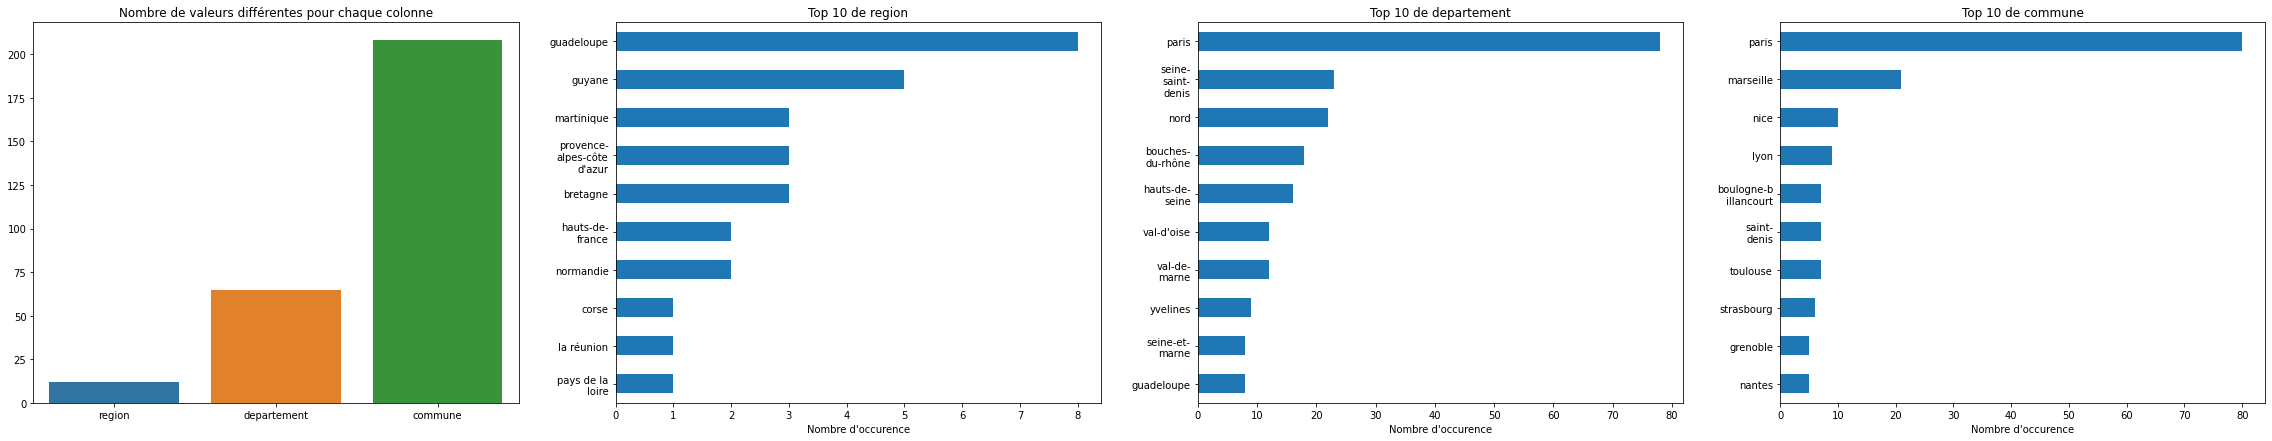

In [225]:
category_count(["region", "departement", "commune"], artist, top=10)

In [226]:
#artiste sans localisation
artist["no localisation"] = (
    (artist["region"].isna()) &
    (artist["commune"].isna()) &
    (artist["departement"].isna())
)

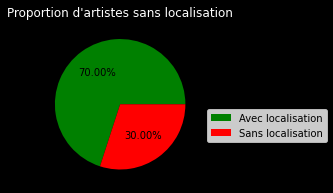

In [227]:
pie_chart(artist, "no localisation", "Proportion d'artistes sans localisation", False, ["Avec localisation", "Sans localisation"])

In [228]:
avant = artist[artist["nationalite"].isna()].shape[0]

# Les artistes pour qui ont a trouvé une commune/departement/region on leur donne la nationalite française
artist.loc[(artist["nationalite"].isna()) & (~artist["no localisation"]), "nationalite"] = "français"

apres = artist[artist["nationalite"].isna()].shape[0]
print(f"On a récupéré {avant-apres} nationalites")

On a récupéré 42 nationalites


In [229]:
#Permet de récupérer le département à partir de la commune
def commune_to_departement(x : str):
    value = commune.loc[commune["nom_commune"] == x, "nom_departement"].values
    if len(value) > 0:
        return value[0]
    else:
        return np.NaN

In [230]:
#On ajoute les departements pour les communes
artist.loc[(~artist["commune"].isna()) & (artist["departement"].isna()), "departement"] = artist.loc[(~artist["commune"].isna()) & (artist["departement"].isna()), "commune"].apply(commune_to_departement)

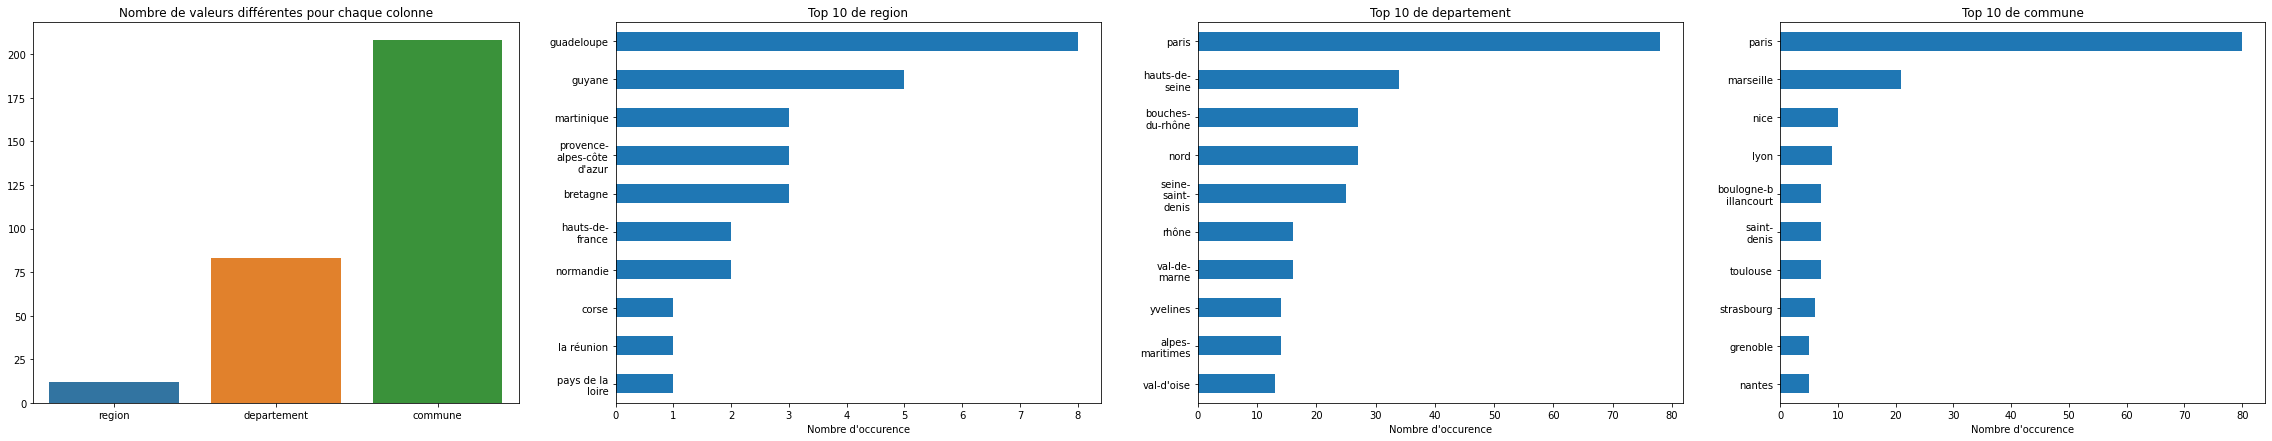

In [231]:
category_count(["region", "departement", "commune"], artist, top=10)

In [232]:
#Permet de récupérer la région à partir du département
def departement_to_region(x : str):
    value = commune.loc[commune["nom_departement"] == x, "nom_region"].values
    if len(value) > 0:
        return value[0]
    else:
        return np.NaN

In [233]:
#On ajoute les regions pour les departements
artist.loc[(~artist["departement"].isna()) & (artist["region"].isna()), "region"] = artist.loc[(~artist["departement"].isna()) & (artist["region"].isna()), "departement"].apply(departement_to_region)

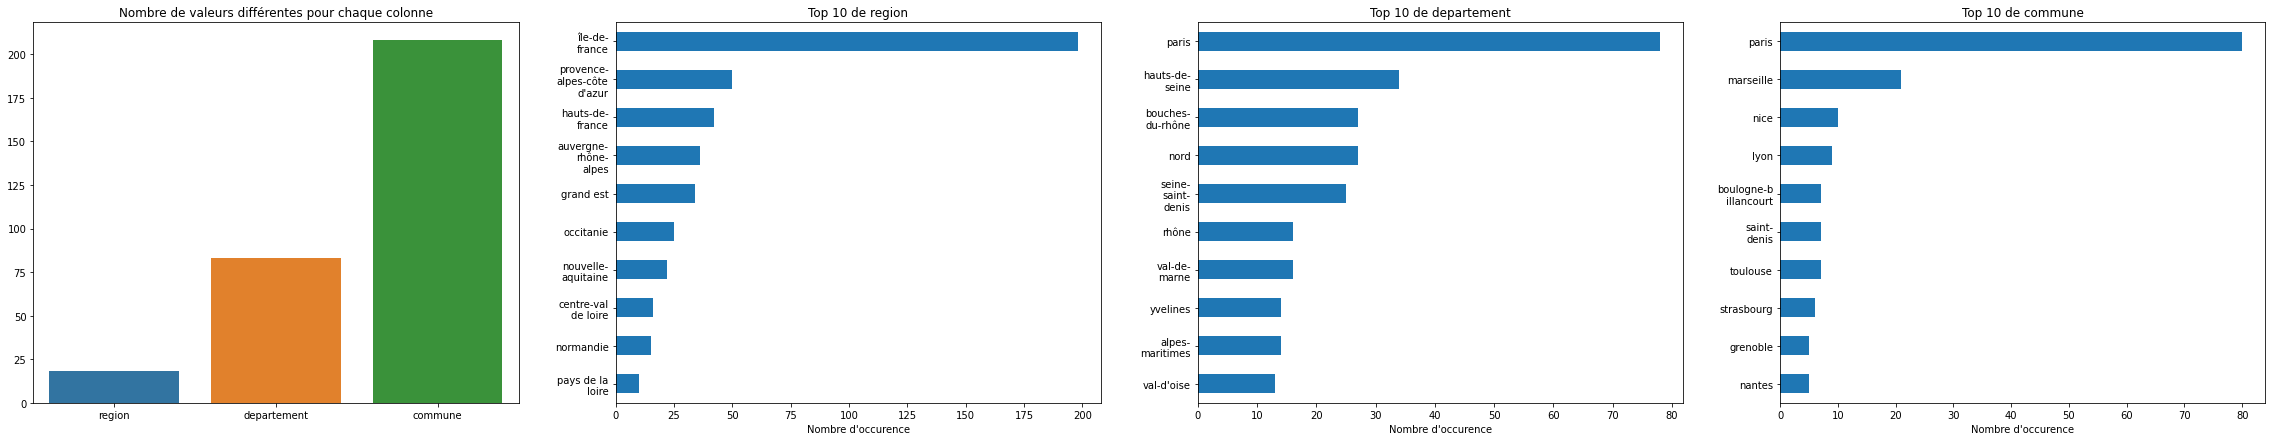

In [234]:
category_count(["region", "departement", "commune"], artist, top=10)

In [235]:
charts_c = charts.copy().merge(artist, left_on="artist", right_on="name", how="left").drop(columns=["rank","annee", "mois"]).drop_duplicates()

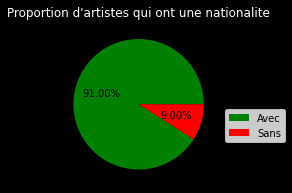

In [236]:
pie_chart(artist, "nationalite", "Proportion d'artistes qui ont une nationalite", True, ["Avec", "Sans"])

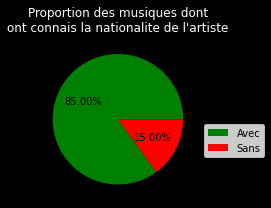

In [237]:
pie_chart(charts_c, "nationalite", "Proportion des musiques dont\nont connais la nationalite de l'artiste", True, ["Avec", "Sans"])

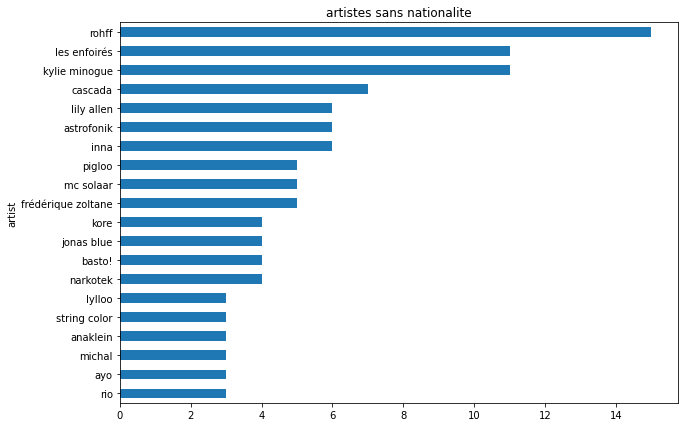

In [238]:
charts_c[charts_c["nationalite"].isna()].groupby("artist")["music"].count().sort_values()[-20:].plot.barh(figsize=(10,7))
plt.title("artistes sans nationalite")
plt.show()

In [239]:
artist.drop(columns=['no data', "no nationalite", "no localisation"], inplace=True)

In [241]:
artist = artist_org[["name"]].merge(artist, on="name", how="left")

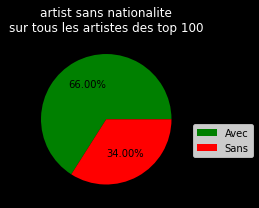

In [242]:
pie_chart(artist, "nationalite", "artist sans nationalite\nsur tous les artistes des top 100", True, ["Avec", "Sans"])

In [243]:
#Export
artist.to_csv("../etapes/4 - cleanning wikipedia results/departement_region/artist.csv", encoding="utf-8-sig", index=False)

## C - Ajout de l'id_artist

In [244]:
artist = pd.read_csv("../etapes/4 - cleanning wikipedia results/departement_region/artist.csv", encoding="utf-8-sig")
charts = pd.read_csv("../etapes/2 - cleanning chart/charts.csv", encoding="utf-8-sig")

In [246]:
# Ajout de l'id
artist = add_id(artist, ["name"], "id_artist")

In [249]:
# On remplace le nom des artistes par leur id dans le charts et on renome le nom de la colonne
charts["artist"] = charts["artist"].apply(lambda x : artist[artist["name"] == x]["id_artist"].values[0])
charts.rename(columns={"artist" : "id_artist"}, inplace=True)

In [250]:
charts.to_csv("../etapes/4 - cleanning wikipedia results/add_id/charts.csv", encoding="utf-8-sig", index=False)
artist.to_csv("../etapes/4 - cleanning wikipedia results/add_id/artist.csv", encoding="utf-8-sig", index=False)

## D - Analyse

In [2]:
#Import
artist = pd.read_csv("../etapes/4 - cleanning wikipedia results/add_id/artist.csv", encoding="utf-8-sig")
charts = pd.read_csv("../etapes/4 - cleanning wikipedia results/add_id/charts.csv", encoding="utf-8-sig")

### 1 - Maps

In [251]:
departement_df = gpd.read_file("../departements-et-collectivites-doutre-mer-france/georef-france-departement-millesime.shp", encoding="utf-8")

In [252]:
region_df = gpd.read_file("../departements-et-collectivites-doutre-mer-france/regions-20180101.shp")

In [253]:
nom_to_suppr = ["Guyane", "La Réunion", "Corse", "Martinique", "Guadeloupe", "Mayote"]
region_df = region_df[~region_df["nom"].isin(nom_to_suppr)]

In [254]:
#Remove overseas departments
idx = []
for dp in ["971", "972", "973", "974", "976"]:
    idx += departement_df[departement_df["dep_code"] == dp].index.tolist()
departement_df.drop(index=idx, inplace=True)

In [255]:
departement_map = departement_df[["dep_name_lo", "geometry"]].copy()
region_map = region_df[["nom", "geometry"]].copy()

In [256]:
region_map["nom"] = region_map["nom"].str.lower()

In [257]:
departement_count = artist.copy().groupby("departement")["wiki name"].count()
region_count = artist.copy().groupby("region")["wiki name"].count()

In [258]:
departement_count = pd.DataFrame(departement_count).merge(departement_map, left_on="departement", right_on="dep_name_lo", how="left")
region_count = pd.DataFrame(region_count).merge(region_map, left_on="region", right_on="nom", how="left")

In [259]:
departement_count = gpd.GeoDataFrame(departement_count, geometry="geometry")
region_count = gpd.GeoDataFrame(region_count, geometry="geometry")

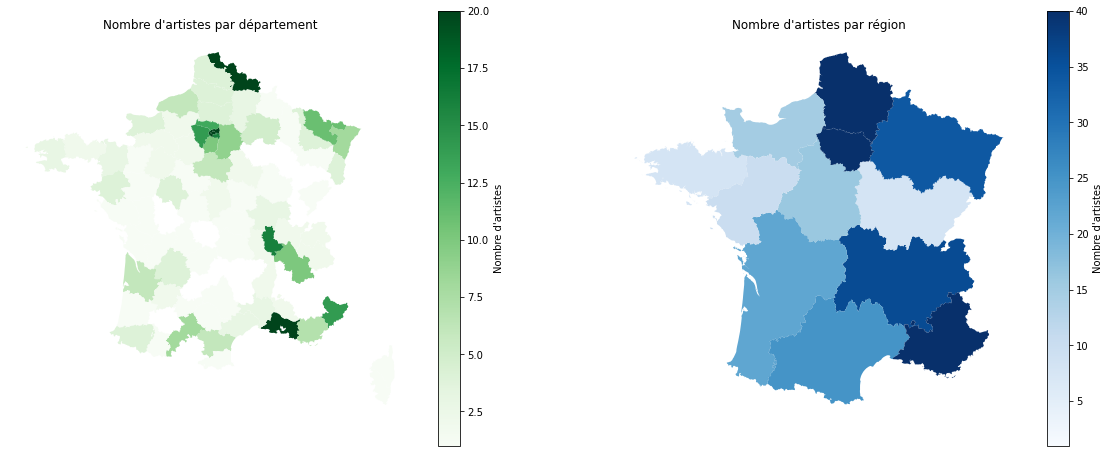

In [260]:
#Plot departement and region on map
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
departement_count.plot(column="wiki name", ax=ax[0], legend=True, legend_kwds={'label': "Nombre d'artistes"}, vmax=20, cmap="Greens")
region_count.plot(column="wiki name", ax=ax[1], legend=True, legend_kwds={'label': "Nombre d'artistes"}, vmax=40, cmap="Blues")
ax[0].set_title("Nombre d'artistes par département")
ax[0].axis("off")
ax[1].set_title("Nombre d'artistes par région")
ax[1].axis("off")
plt.show()

# Etape 5 : Scrapping parole

## A - Code

In [261]:
#Import
artist = pd.read_csv("../etapes/4 - cleanning wikipedia results/add_id/artist.csv", encoding="utf-8-sig")
charts = pd.read_csv("../etapes/4 - cleanning wikipedia results/add_id/charts.csv", encoding="utf-8-sig")

In [308]:
gentilles_francophones = [
    "africains",
    "sud-africains",
    "algériens",
    "belges",
    "beninois",
    "burkinabais",
    "burundais",
    "camerounais",
    "canadiens",
    "centrafricains",
    "congolais",
    "ivoiriens",
    "français",
    "gabonais",
    "guinéens",
    "haïtiens",
    "libanais",
    "maliens",
    "marocains",
    "mauriciens",
    "mauritaniens",
    "néo-zélandais",
    "québécois",
    "sénégalais",
    "tunisiens"
]

In [309]:
artist_francophone = artist[artist["nationalite"].isin(gentilles_francophones)]

In [310]:
charts_francophone = charts.merge(artist_francophone, left_on="id_artist", right_on="id_artist", how="right")[["id_artist", "id_music", "artist", "music"]].drop_duplicates()

In [64]:
charts_francophone["lyrics"] = charts_francophone.apply(find_lyrics, axis=1)

In [319]:
musics = charts_francophone[["id_music", "id_artist", "music", "lyrics"]]

In [320]:
#export
musics.to_csv("../etapes/5 - scrapping lyrics/musics.csv", encoding="utf-8-sig", index=False)

## B - Analyse

In [321]:
#import
musics = pd.read_csv("../etapes/5 - scrapping lyrics/musics.csv", encoding="utf-8-sig")
artist = pd.read_csv("../etapes/4 - cleanning wikipedia results/add_id/artist.csv", encoding="utf-8-sig")

In [322]:
data = musics.merge(artist, on="id_artist", how="left")

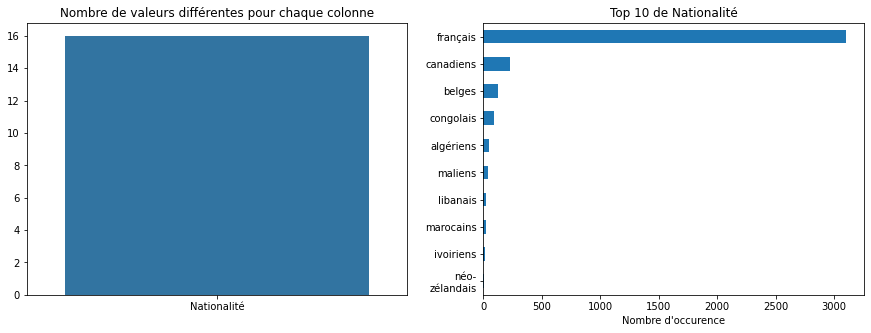

In [323]:
category_count(["nationalite"], data, (15,5))

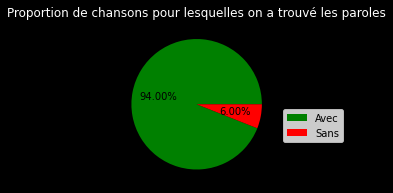

In [324]:
pie_chart(charts_francophone, "lyrics", "Proportion de chansons pour lesquelles on a trouvé les paroles", True, ["Avec", "Sans"])

# Etape 6 : Cleaning des paroles

## A - Cleaning

In [325]:
#import
musics = pd.read_csv("../etapes/5 - scrapping lyrics/musics.csv", encoding="utf-8-sig")

In [332]:
musics["lyrics"] = musics.apply(cleanning_lyrics, axis=1)

<strong> J'ai des musiques qui ne sont pas en VO </strong>

In [333]:
#export
musics.to_csv("../etapes/6 - cleaning lyrics/musics.csv", encoding="utf-8-sig", index=False)

## B - Analyse

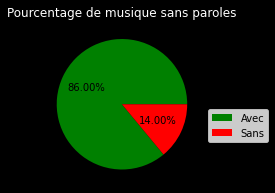

In [334]:
pie_chart(musics, "lyrics", "Pourcentage de musique sans paroles", True, ["Avec", "Sans"])

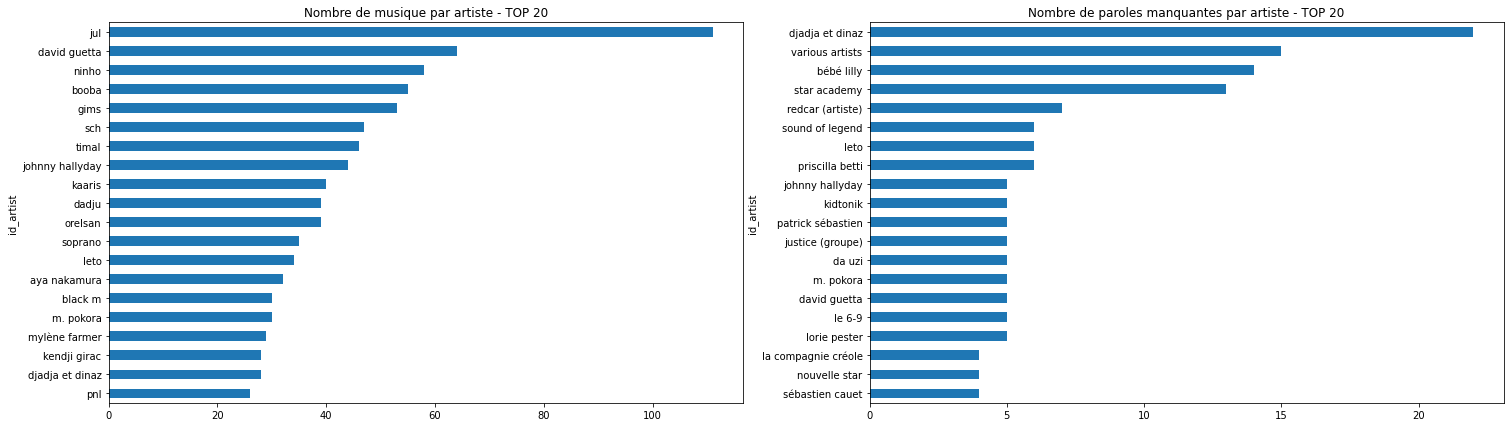

In [335]:
top = 20

fig, ax = plt.subplots(1, 2, figsize=(25, 7))

musics.groupby("id_artist")["music"].count().sort_values(ascending=True).iloc[-top:].plot.barh(ax=ax[0])
ax[0].set_yticklabels([artist[artist["id_artist"] == int(label.get_text())]["artist"].values[0] for label in ax[0].get_yticklabels()])
ax[0].set_title(f"Nombre de musique par artiste - TOP {top}")

musics[musics["lyrics"].isna()].groupby("id_artist")["music"].count().sort_values(ascending=True).iloc[-top:].plot.barh(ax=ax[1])
ax[1].set_yticklabels([artist[artist["id_artist"] == int(label.get_text())]["artist"].values[0] for label in ax[1].get_yticklabels()])
ax[1].set_title(f"Nombre de paroles manquantes par artiste - TOP {top}")

plt.show()

# Etape 7 - TF-IDF

## A - Spacy FR

In [336]:
#import
musics = pd.read_csv("../etapes/6 - cleaning lyrics/musics.csv", encoding="utf-8-sig")

In [32]:
# Charge le modèle de langue française
nlp = spacy.load("fr_core_news_sm")

In [339]:
musics["is french"] = musics["lyrics"].apply(is_french)

In [340]:
#export
musics.to_csv("../etapes/7 - lematization/isFrench/musics.csv", encoding="utf-8-sig", index=False)

## B - TF-IDF

In [2]:
#import
musics = pd.read_csv("../etapes/7 - lematization/isFrench/musics.csv", encoding="utf-8-sig")
charts = pd.read_csv("../etapes/4 - cleanning wikipedia results/add_id/charts.csv", encoding="utf-8-sig")

In [3]:
nlp = spacy.load("fr_core_news_sm")

In [4]:
musics = musics[musics["is french"]]
lyrics_lematization = musics["Lyrics"].apply(lambda x : lematization(x, nlp))

In [5]:
tfidf = tfidf_mat(lyrics_lematization)

In [6]:
tfidf.index = musics["id_music"].to_list()

In [17]:
(tfidf == 0).sum().sum()/(tfidf.shape[0]*tfidf.shape[1])

0.9970314534444145

In [23]:
tfidf.to_csv("../etapes/7 - lematization/tfidf/tfidf.csv")

## B - Clustering

In [2]:
from sklearn.cluster import KMeans

In [3]:
#import
tfidf = pd.read_csv("../etapes/7 - lematization/tfidf/tfidf.csv", header=0, index_col=0)

In [5]:
range = np.arange(2,50,2)

inertia = []
for n in tqdm(range):
    km = KMeans(n_clusters=n)
    km.fit(tfidf)
    inertia.append(km.inertia_)

NameError: name 'tqdm' is not defined

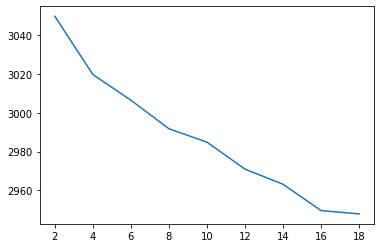

In [ ]:
plt.plot(range , inertia)

## C - Analyse

In [343]:
#import
musics = pd.read_csv("../etapes/7 - lematization/isFrench/musics.csv", encoding="utf-8-sig")

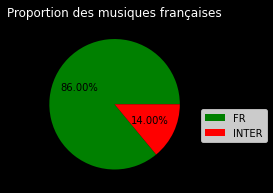

In [341]:
pie_chart(musics, "is french", "Proportion des musiques françaises", False, ["FR", "INTER"])

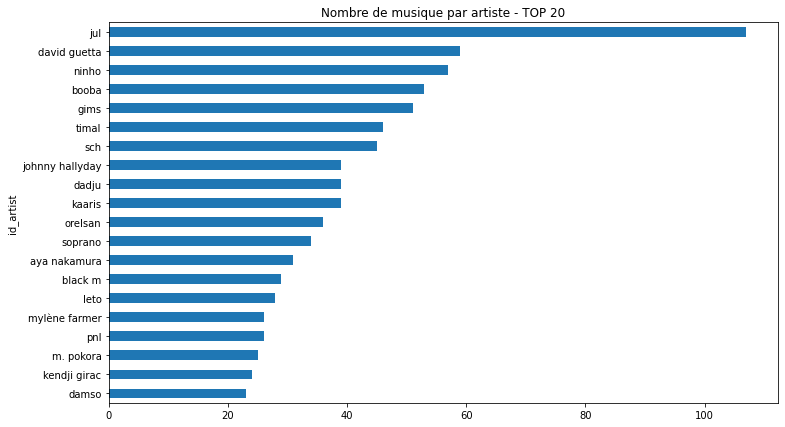

In [342]:
top = 20

musics = musics[musics["is french"]]

fig, ax = plt.subplots(figsize=(12, 7))

musics.groupby("id_artist")["music"].count().sort_values(ascending=True).iloc[-top:].plot.barh(ax=ax)
ax.set_yticklabels([artist[artist["id_artist"] == int(label.get_text())]["artist"].values[0] for label in ax.get_yticklabels()])
ax.set_title(f"Nombre de musique par artiste - TOP {top}")

plt.show()